In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#!unzip -u "/content/drive/MyDrive/AI for Diagnosis & Prognosis/Dataset/archive.zip" -d "/content/drive/MyDrive/AI for Diagnosis & Prognosis/Dataset/"

In [3]:
from keras.layers import Input, Dense, Flatten,Dropout
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/AI for Diagnosis & Prognosis/Dataset/Fold1/Fold1/Fold1/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary',subset="training")
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/AI for Diagnosis & Prognosis/Dataset/Fold1/Fold1/Fold1/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')
val_set = valid_datagen.flow_from_directory('/content/drive/MyDrive/AI for Diagnosis & Prognosis/Dataset/Fold1/Fold1/Fold1/Val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 2142 images belonging to 2 classes.
Found 45 images belonging to 2 classes.
Found 254 images belonging to 2 classes.


In [6]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [7]:
training_set.class_indices

{'Monkeypox': 0, 'Others': 1}

In [8]:
train_y.shape,test_y.shape,val_y.shape

((2142,), (45,), (254,))

# CUSTOMIZED CNN

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense,Conv2D,AveragePooling2D,Flatten,Dropout, MaxPool2D)

model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D((2,2), strides = (2,2)))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPool2D((2,2), strides = (2,2)))


model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPool2D((2,2), strides = (2,2)))
model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [11]:
model.compile(
  loss='binary_crossentropy',
  optimizer="ADAM",
  metrics=['accuracy']
)

In [12]:
#Early stopping to avoid overfitting of model
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [14]:
# fit the model
history = model.fit(
   training_set,
  validation_data=val_set,
  epochs=20,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/20
67/67 [==============================] - 341s 5s/step - loss: 0.7159 - accuracy: 0.6111 - val_loss: 0.6471 - val_accuracy: 0.5157
Epoch 2/20
67/67 [==============================] - 9s 132ms/step - loss: 0.6311 - accuracy: 0.6265 - val_loss: 0.6617 - val_accuracy: 0.4921
Epoch 3/20
67/67 [==============================] - 8s 124ms/step - loss: 0.5410 - accuracy: 0.7292 - val_loss: 1.0122 - val_accuracy: 0.4685
Epoch 4/20
67/67 [==============================] - 8s 121ms/step - loss: 0.4868 - accuracy: 0.7530 - val_loss: 0.8070 - val_accuracy: 0.5118
Epoch 5/20
67/67 [==============================] - 9s 131ms/step - loss: 0.4171 - accuracy: 0.8133 - val_loss: 1.3576 - val_accuracy: 0.4567
Epoch 6/20
67/67 [==============================] - 8s 119ms/step - loss: 0.3727 - accuracy: 0.8324 - val_loss: 0.9471 - val_accuracy: 0.5669
Epoch 6: early stopping


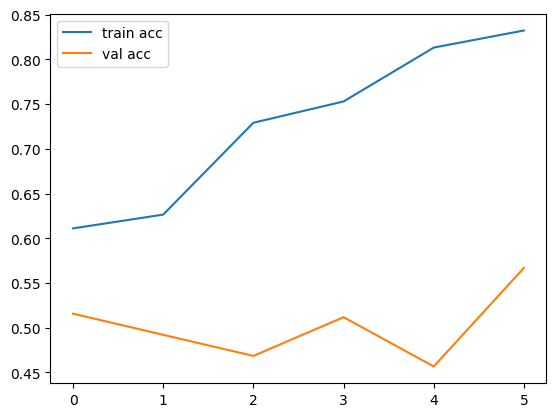

In [15]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()


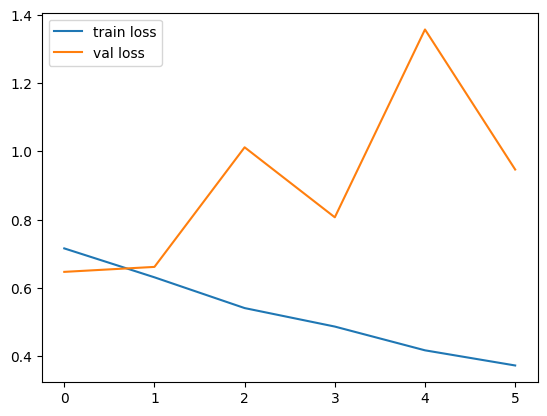

In [16]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [60]:
score = model.evaluate_generator(test_set)
custom_accu = score[1]
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<ipython-input-60-f6a0c1e48383>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(test_set)


Test loss: 2.256014108657837
Test accuracy: 0.6666666865348816


#VGG19

In [18]:
vgg19 = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 0s 0us/step


In [19]:
for layer in vgg19.layers:
    layer.trainable = False

In [20]:
x = Flatten()(vgg19.output)
x=Dense(4096, activation='relu')(x)
x=Dense(4096, activation='relu')(x)
x=Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

In [21]:
model1 = Model(inputs=vgg19.input, outputs=prediction)

In [22]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [23]:
model1.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [24]:
# fit the model
history1 = model1.fit(
 training_set,
  validation_data=val_set,
  epochs=50,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/50
67/67 [==============================] - 26s 278ms/step - loss: 2.3679 - accuracy: 0.5882 - val_loss: 0.7894 - val_accuracy: 0.5118
Epoch 2/50
67/67 [==============================] - 13s 199ms/step - loss: 0.4556 - accuracy: 0.7908 - val_loss: 0.8293 - val_accuracy: 0.6260
Epoch 3/50
67/67 [==============================] - 13s 197ms/step - loss: 0.3048 - accuracy: 0.8739 - val_loss: 1.3466 - val_accuracy: 0.5433
Epoch 4/50
67/67 [==============================] - 14s 212ms/step - loss: 0.2491 - accuracy: 0.8889 - val_loss: 1.5249 - val_accuracy: 0.6220
Epoch 5/50
67/67 [==============================] - 13s 199ms/step - loss: 0.2650 - accuracy: 0.8805 - val_loss: 1.5319 - val_accuracy: 0.5157
Epoch 6/50
67/67 [==============================] - 14s 202ms/step - loss: 0.2360 - accuracy: 0.8978 - val_loss: 1.5757 - val_accuracy: 0.4843
Epoch 6: early stopping


In [25]:
score = model1.evaluate_generator(test_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<ipython-input-25-3ec7817b7737>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model1.evaluate_generator(test_set)


Test loss: 0.6662021279335022
Test accuracy: 0.7333333492279053


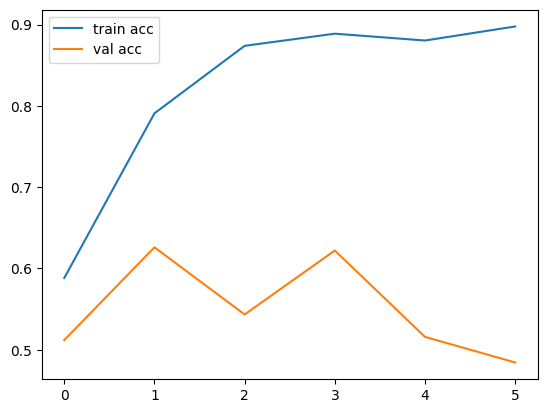

In [26]:
# accuracies

plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

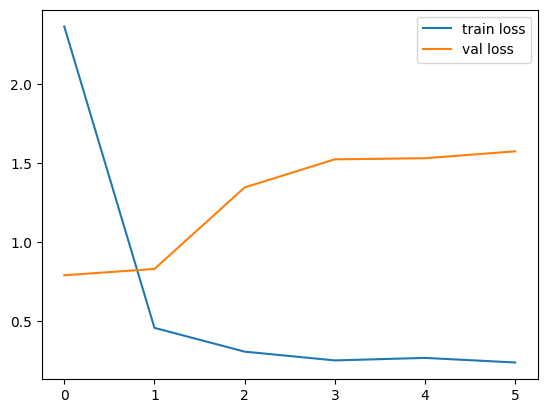

In [27]:
# loss
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [59]:
score = model1.evaluate_generator(test_set)
vgg19_accu = score[1]
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<ipython-input-59-7dad6ec71727>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model1.evaluate_generator(test_set)


Test loss: 1.2004477977752686
Test accuracy: 0.7333333492279053


# VGG16


In [28]:
vgg16 = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [29]:
for layer in vgg16.layers:
    layer.trainable = False

In [30]:
x = Flatten()(vgg16.output)
x=Dense(4096, activation='relu')(x)
x=Dense(4096, activation='relu')(x)
x=Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

In [32]:
model3 = Model(inputs=vgg16.input, outputs=prediction)

In [33]:
# view the structure of the model
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [34]:
model3.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [35]:
# fit the model
history2 = model1.fit(
 training_set,
  validation_data=val_set,
  epochs=50,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/50
67/67 [==============================] - 15s 219ms/step - loss: 0.1859 - accuracy: 0.9216 - val_loss: 1.1945 - val_accuracy: 0.4961
Epoch 2/50
67/67 [==============================] - 14s 206ms/step - loss: 0.1622 - accuracy: 0.9337 - val_loss: 1.9364 - val_accuracy: 0.5827
Epoch 3/50
67/67 [==============================] - 13s 197ms/step - loss: 0.1921 - accuracy: 0.9192 - val_loss: 1.8005 - val_accuracy: 0.5866
Epoch 4/50
67/67 [==============================] - 13s 197ms/step - loss: 0.1485 - accuracy: 0.9328 - val_loss: 2.0746 - val_accuracy: 0.6102
Epoch 5/50
67/67 [==============================] - 13s 197ms/step - loss: 0.1024 - accuracy: 0.9585 - val_loss: 2.2649 - val_accuracy: 0.5472
Epoch 6/50
67/67 [==============================] - 13s 199ms/step - loss: 0.1697 - accuracy: 0.9379 - val_loss: 2.5692 - val_accuracy: 0.4843
Epoch 6: early stopping


In [58]:
score = model3.evaluate_generator(test_set)
vgg16_accu = score[1]
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<ipython-input-58-adcefa686442>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model3.evaluate_generator(test_set)


Test loss: 0.6823620200157166
Test accuracy: 0.5555555820465088


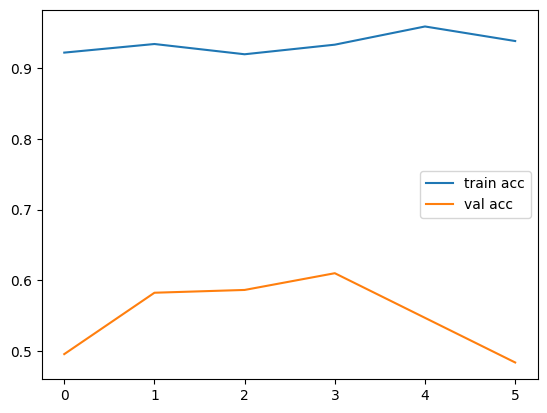

In [37]:
# accuracies

plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

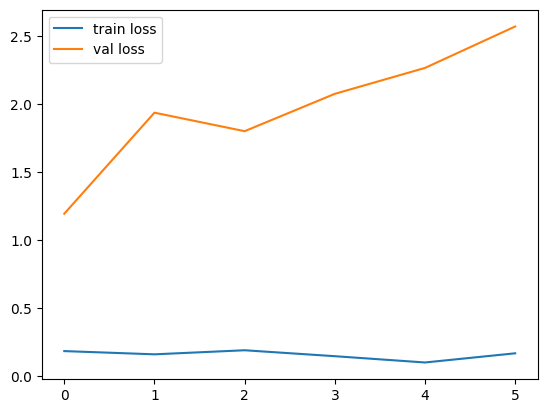

In [38]:
# loss
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# RESNET50

In [39]:
resnet = ResNet50(input_shape=(224,224,3), weights=None, include_top=False)

In [40]:
for layer in resnet.layers:
    layer.trainable = False

In [41]:
x = Flatten()(resnet.output)
x=Dense(4096, activation='relu')(x)
x=Dense(4096, activation='relu')(x)
x=Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

In [42]:
model4 = Model(inputs=resnet.input, outputs=prediction)

In [43]:
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [44]:
model4.compile(
  loss='binary_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [45]:
# fit the model
history3 = model4.fit(
 training_set,
  validation_data=val_set,
  epochs=50,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/50
67/67 [==============================] - 22s 238ms/step - loss: 1.3805 - accuracy: 0.5233 - val_loss: 0.7415 - val_accuracy: 0.3386
Epoch 2/50
67/67 [==============================] - 13s 197ms/step - loss: 0.6806 - accuracy: 0.5518 - val_loss: 0.6819 - val_accuracy: 0.5709
Epoch 3/50
67/67 [==============================] - 13s 198ms/step - loss: 0.6615 - accuracy: 0.6018 - val_loss: 0.6461 - val_accuracy: 0.5748
Epoch 4/50
67/67 [==============================] - 13s 194ms/step - loss: 0.6417 - accuracy: 0.6321 - val_loss: 0.6601 - val_accuracy: 0.5630
Epoch 5/50
67/67 [==============================] - 13s 196ms/step - loss: 0.6113 - accuracy: 0.6746 - val_loss: 0.7022 - val_accuracy: 0.4685
Epoch 6/50
67/67 [==============================] - 13s 196ms/step - loss: 0.6072 - accuracy: 0.6601 - val_loss: 0.7543 - val_accuracy: 0.5197
Epoch 7/50
67/67 [==============================] - 13s 196ms/step - loss: 0.5639 - accuracy: 0.7120 - val_loss: 0.6852 - val_accuracy: 0.5197

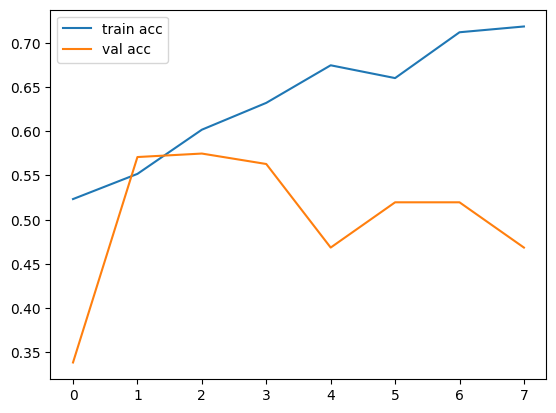

In [46]:
# accuracies

plt.plot(history3.history['accuracy'], label='train acc')
plt.plot(history3.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

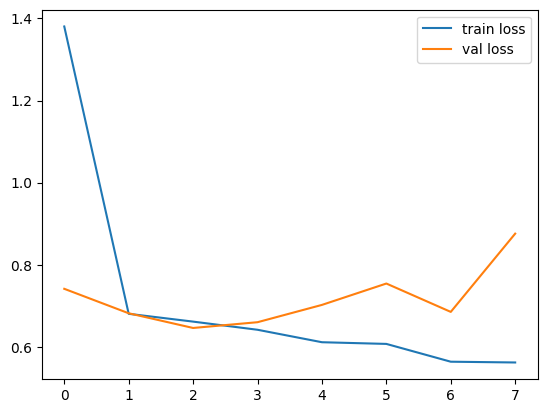

In [47]:
# loss
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [56]:
score = model4.evaluate_generator(test_set)
resnet_accu = score[1]
print('Test loss:', score[0])
print('Test accuracy:', score[1])

<ipython-input-56-8e8c9d9f02fb>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model4.evaluate_generator(test_set)


Test loss: 0.7097933292388916
Test accuracy: 0.6666666865348816


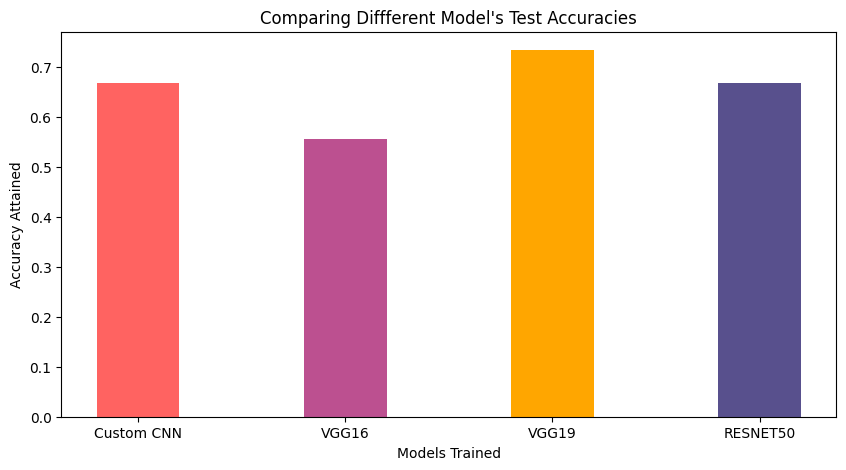

In [72]:
import numpy as np
import matplotlib.pyplot as plt


data = {'Custom CNN':custom_accu, 'VGG16':vgg16_accu, 'VGG19':vgg19_accu,
		'RESNET50':resnet_accu}
model = list(data.keys())
accuracy_values = list(data.values())

fig = plt.figure(figsize = (10, 5))

plt.bar(model, accuracy_values,	width = 0.4,color=['#ff6361', '#bc5090', '#ffa600', '#58508d'])

plt.xlabel("Models Trained")
plt.ylabel("Accuracy Attained")
plt.title("Comparing Diffferent Model's Test Accuracies")
plt.show()
